In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# Hyper-parameters 
input_size = 32*32 # 32x32
hidden_dim = 16
latent_dim = 400 
num_classes = 10
num_epochs = 3
batch_size = 200
learning_rate = 1e-3

In [3]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
inv_normalize = transforms.Normalize((-0.5/0.5, -0.5/0.5, -0.5/0.5), (1/0.5, 1/0.5, 1/0.5))


# CIFAR10 Data: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True,
                                                download=True, transform=cifar_transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False,
                                                download=True, transform=cifar_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


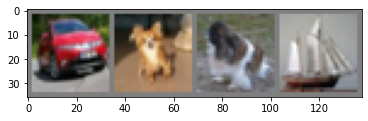

In [4]:
# Visualise sample of images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:4])

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(img_grid)

# write to tensorboard
writer.add_image('four_cifar10_images', inv_normalize(img_grid))

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_channels, feature_dim=32*32, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, padding=1) # set padding 1 for feature_dim == image_size
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc_mu = nn.Linear(hidden_dim*feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim*feature_dim, latent_dim)
    
    def forward(self, x): # x = [batch_size, input_channels, 32, 32]
        x = F.relu(self.conv1(x))  # (input width - filter size + 2*padding)/stride + 1 : (32 - 3 + 2) + 1 = 32
        x = F.relu(self.conv2(x))  # x.shape = [batch, n_filters, 32, 32]
        x = x.view(-1, self.hidden_dim*32*32)
        self.mu = self.fc_mu(x)
        self.logvar = self.fc_logvar(x)
        return self.mu, self.logvar


In [6]:
class Decoder(nn.Module):
    def __init__(self, input_channels, feature_dim=32*32, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(Decoder, self).__init__()
        self.fc_z = nn.Linear(latent_dim, hidden_dim*feature_dim)
        self.deconv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, input_channels, kernel_size=3, padding=1)

    def forward(self, z): # z.shape : [batch_size, latent_dim]
        x_hat = F.relu(self.fc_z(z))
        x_hat = x_hat.view(-1, hidden_dim, 32, 32)
        x_hat = F.relu(self.deconv1(x_hat))
        x_hat = torch.tanh(self.deconv2(x_hat))
        return x_hat
    

In [15]:
# Loss function adapted from https://github.com/williamFalcon/pytorch-lightning-vae/blob/main/vae.py 
class VAE(nn.Module):
    def __init__(self, input_channels=3, feature_dim=32*32, hidden_dim=hidden_dim, latent_dim=latent_dim) -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels=input_channels, 
                               feature_dim=feature_dim, 
                               hidden_dim=hidden_dim, 
                               latent_dim=latent_dim)
        self.decoder = Decoder(input_channels=input_channels, 
                               feature_dim=feature_dim, 
                               hidden_dim=hidden_dim, 
                               latent_dim=latent_dim)
        
        # For the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0])) 
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        prior_dist = torch.distributions.Normal(mean, scale) # N[0,1]

        # Measure prob of seeing image under p(x|z)
        log_pxz = prior_dist.log_prob(x)
        return log_pxz.sum(dim=(1,2,3)) # [batch_size, input_channels, 32, 32], keep batch dimension

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. Define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. Get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # KL divergence
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    

    def forward(self, x):
        # Inference
        mu, logvar = self.encoder(x)

        # Reparametrisation
        std = torch.exp(logvar / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # Generate
        x_hat = self.decoder(z)
        
        # Reconstruction loss
        reconstruction_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # KL
        kl = self.kl_divergence(z, mu, std)

        # ELBO: minimising KL == maximising ELBO
        neg_elbo = (kl - reconstruction_loss)
        neg_elbo = neg_elbo.mean()
        
        return mu, logvar, neg_elbo, x_hat

In [ ]:
# Using MSE for reconstruction loss may be inappropriate, see section 5.1 in https://arxiv.org/pdf/2006.10273 
def MSE_loss(x, x_hat, mu, logvar):
    reconstruction_loss = F.mse_loss(x_hat, x, reduction="sum") # Note: MSE loss may be inappropriate
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss - kl_divergence

In [10]:
n_training_samples = len(train_dataset) # 50000
n_iterations = math.ceil(n_training_samples/batch_size)

vae_model = VAE(input_channels=3) 
optimiser = torch.optim.Adam(list(vae_model.parameters()), lr=learning_rate)
print("Start training...")
for epoch in range(num_epochs):
    overall_loss = 0
    since = time.time()
    for i, (image, label) in enumerate(train_loader):
        #image shape 4, 3, 32, 32 -> 4, 3, 1024
        
        optimiser.zero_grad()

        # VAE forward pass
        mu, logvar, loss, x_hat = vae_model(image)
        
        # loss = MSE_loss(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()
        
        if (i+1) % 50 == 0:
            time_elapsed = time.time() - since
            #print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, image: {image.shape}")
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_iterations}, avg loss: {overall_loss/(i*batch_size):.3f}, time: {time_elapsed:.2f}")
            
print("Training completed.")

Start training...
epoch: 1/3, step: 50/250, avg loss: 15.817, time: 52.72
epoch: 1/3, step: 100/250, avg loss: 15.008, time: 104.51
epoch: 1/3, step: 150/250, avg loss: 14.448, time: 155.77
epoch: 1/3, step: 200/250, avg loss: 13.976, time: 208.85
epoch: 1/3, step: 250/250, avg loss: 13.545, time: 261.82
epoch: 2/3, step: 50/250, avg loss: 11.334, time: 52.24
epoch: 2/3, step: 100/250, avg loss: 10.869, time: 105.22
epoch: 2/3, step: 150/250, avg loss: 10.475, time: 158.34
epoch: 2/3, step: 200/250, avg loss: 10.105, time: 210.47
epoch: 2/3, step: 250/250, avg loss: 9.744, time: 261.14
epoch: 3/3, step: 50/250, avg loss: 7.768, time: 51.89
epoch: 3/3, step: 100/250, avg loss: 7.337, time: 107.73
epoch: 3/3, step: 150/250, avg loss: 6.974, time: 163.57
epoch: 3/3, step: 200/250, avg loss: 6.626, time: 215.46
epoch: 3/3, step: 250/250, avg loss: 6.285, time: 270.32
Training completed.


In [11]:
vae_model.eval()
def make_image_grids():
    with torch.no_grad():

        # Visualise sample of images
        dataiter = iter(test_loader)
        images, _ = dataiter.next()

        # Generate x_hat from z, given x
        *_, x_hat = vae_model(images)
        
        # create grid of images
        start = 0
        count = 4
        img_grid = torchvision.utils.make_grid(images[start:start+count])
        x_hat_grid =  torchvision.utils.make_grid(x_hat[start:start+count])
        
        return img_grid, x_hat_grid
    

In [12]:
def stats(x):
    return x.mean(), x.std()
stats(images[0][0].view(-1)), stats(x_hat[0][0].view(-1))

((tensor(-0.1584), tensor(0.5191)),
 (tensor(0.1277, grad_fn=<MeanBackward0>),
  tensor(0.3757, grad_fn=<StdBackward0>)))

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

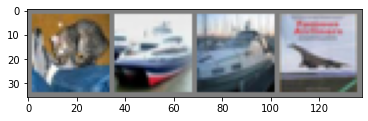

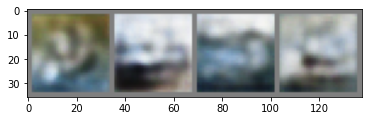

In [14]:
img_grid, x_hat_grid = make_image_grids()
# show images
imshow(img_grid)
imshow(x_hat_grid)

# write to tensorboard
# writer.add_image('four_cifar10_images', inv_normalize(img_grid))